#Identifying Game Review Attribution with Alibi Gradients

Authors: Jason Phillips & Peeja Khorashadi

Date: 05/01/2023

CSC 215-01

Summary: Utilizing a dataset of Steam reviews for popular games, we are trying to identify the key attributes/words that contribute to a person recommending the game or not.

Dataset:https://www.kaggle.com/datasets/arashnic/game-review-dataset

Papers Refrenced: https://ieeexplore-ieee-org.proxy.lib.csus.edu/document/9752380 , https://ieeexplore-ieee-org.proxy.lib.csus.edu/document/9950194 , https://www.kaggle.com/code/mehmetlaudatekman/game-review-classification-deep-learning-based , https://github.com/SeldonIO/alibi

#Import and Define
Import necessary libraries and define useful functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install tf-explain
# !pip install --upgrade gensim
#!pip install alibi[tensorflow]
!pip install alibi
!pip install --upgrade alibi

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
#import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime
import string
import torch
import random

from alibi.explainers import IntegratedGradients

from scipy.stats import zscore
from scipy import spatial

from collections.abc import Sequence
from collections import Counter
from numpy import where
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,LSTM
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers


from gensim.models import Word2Vec, KeyedVectors
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from pprint import pprint

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))

#Remove any files in the log folder for tensorboard
#!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Data Preprocessing (Training Dataset)
NOTES: 

**Should we include numbers in the tokenized text?**

**Will different genres effect our model?** 

In [ ]:
#Read the review dataset from the training folder
filename_read = "https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/Final%20Project/train.csv"
df_train = pd.read_csv(filename_read, sep=',', header=0)
df_train

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


In [ ]:
#Print out the different games used in this review.
#NOTE: Remove the ® symbol from smite and elder scrolls later.
print("Number of titles in the dataset: " + str(df_train['title'].nunique()))
print(df_train['title'].unique())

Number of titles in the dataset: 44
["Spooky's Jump Scare Mansion" 'Sakura Clicker' 'WARMODE'
 'Fractured Space' 'Dota 2' 'Path of Exile' 'War Thunder'
 'Ring of Elysium' 'Team Fortress 2' 'Yu-Gi-Oh! Duel Links' 'SMITE®'
 'Brawlhalla' 'World of Tanks Blitz' 'DCS World Steam Edition'
 'Heroes & Generals' 'The Elder Scrolls®: Legends™' 'Trove' 'Neverwinter'
 'Realm Royale' 'PlanetSide 2' 'Realm of the Mad God' 'Elsword'
 'theHunter Classic' 'Eternal Card Game' 'Black Squad'
 'Freestyle 2: Street Basketball' 'Bless Online'
 'RaceRoom Racing Experience' 'Fallout Shelter'
 'Tactical Monsters Rumble Arena' 'Creativerse' 'Dreadnought'
 'Infestation: The New Z' 'Shop Heroes' 'Robocraft'
 'Business Tour - Board Game with Online Multiplayer'
 'Crusaders of the Lost Idols' 'AdventureQuest 3D' 'Realm Grinder'
 'World of Guns: Gun Disassembly' 'Bloons TD Battles' 'Cuisine Royale'
 'School of Dragons' 'EverQuest II']


In [ ]:
#Drop unnecessary columns
df_train = df_train.drop(['review_id', 'year'], axis=1)
df_train

,title,user_review,user_suggestion
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1
...,...,...,...
17489,EverQuest II,Arguably the single greatest mmorp that exists...,1
17490,EverQuest II,"An older game, to be sure, but has its own cha...",1
17491,EverQuest II,When I frist started playing Everquest 2 it wa...,1
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1


In [ ]:
#Check if any values are empty or null
df_train[df_train.isnull().any(axis=1)]

,title,user_review,user_suggestion


In [ ]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_train['tokenized'] = df_train['user_review'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_train

,title,user_review,user_suggestion,tokenized
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,"[i'm, scared, and, hearing, creepy, voices, so..."
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,"[best, game, more, better, than, sam, pepper's..."
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1,"[a, littly, iffy, on, the, controls, but, once..."
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,"[great, game, fun, and, colorful, and, all, th..."
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,"[not, many, games, have, the, cute, tag, right..."
...,...,...,...,...
17489,EverQuest II,Arguably the single greatest mmorp that exists...,1,"[arguably, the, single, greatest, mmorp, that,..."
17490,EverQuest II,"An older game, to be sure, but has its own cha...",1,"[an, older, game, to, be, sure, but, has, its,..."
17491,EverQuest II,When I frist started playing Everquest 2 it wa...,1,"[when, i, frist, started, playing, everquest, ..."
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,"[cool, game, the, only, thing, that, really, p..."


In [ ]:
#Drop rows that have more than 150 words
df_train=df_train[df_train["tokenized"].str.len() <= 100]
df_train=df_train[df_train["tokenized"].str.len() > 3]
df_train=df_train[~df_train["user_review"].str.contains(r'[~@#$%^*/\|<>♥¥™_=+◕ヘ░▄▐☉ʖ]')] 
df_train

,title,user_review,user_suggestion,tokenized
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,"[great, game, fun, and, colorful, and, all, th..."
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,"[not, many, games, have, the, cute, tag, right..."
6,Spooky's Jump Scare Mansion,Great game. it's a cute little horror game tha...,1,"[great, game, it's, a, cute, little, horror, g..."
9,Spooky's Jump Scare Mansion,This game with its cute little out of the wall...,1,"[this, game, with, its, cute, little, out, of,..."
13,Spooky's Jump Scare Mansion,Early Access ReviewGreat game. It always has ...,1,"[early, access, reviewgreat, game, it, always,..."
...,...,...,...,...
17486,EverQuest II,I have always loved this game! I love the idea...,1,"[i, have, always, loved, this, game, i, love, ..."
17487,EverQuest II,After I had played it extensively for four yea...,1,"[after, i, had, played, it, extensively, for, ..."
17488,EverQuest II,this was the first MMORPG i've ever played but...,0,"[this, was, the, first, mmorpg, i've, ever, pl..."
17492,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,"[cool, game, the, only, thing, that, really, p..."


In [ ]:
df_train.reset_index(inplace = True)
df_train

In [ ]:
#df_test = df_train.sample(frac = .2, random_state = 2)
#df_train = df_train.drop(df_test.index)

In [ ]:
#df_test

#Data Preprocessing (Test Dataset) COMPLETELY USELESS CUZ THERE ARE NO LABELS!!! -______-
NOTES: 

**Should we include numbers in the tokenized text?**

**Will different genres effect our model?** 

**There are different game compared to the training dataset**

In [ ]:
#Read the review dataset from the training folder
filename_read = "https://raw.githubusercontent.com/JasonTPhillipsJr/CSC215/main/Final%20Project/test.csv"
df_test = pd.read_csv(filename_read, sep=',', header=0)
print("Test data shape: " + str(df_test.shape))
df_test

Test data shape: (8045, 4)


,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...
...,...,...,...,...
8040,25198,GUNS UP!,2017.0,Early Access ReviewGuns UP!Positive: Good Idea...
8041,25199,GUNS UP!,2018.0,"After 170 hrs, my review. DO NOT SPEND ANY MON..."
8042,25200,GUNS UP!,2018.0,Pros:-Fun GameplayCons: -Micro %$#*ing transac...
8043,25201,GUNS UP!,2018.0,"Actualy saucy, I definetly suggest to players ..."


In [ ]:
#Print out the different games used in this review.
#NOTE: Remove the ® symbol from smite and elder scrolls later.
print("Number of titles in the dataset: " + str(df_test['title'].nunique()))
print(df_test['title'].unique())

Number of titles in the dataset: 20
['Counter-Strike: Global Offensive' 'World of Warships' 'Star Trek Online'
 'Paladins®' 'Shadowverse CCG' 'Tree of Savior (English Ver.)'
 'VEGA Conflict' 'Minion Masters' 'The Lord of the Rings Online™'
 'Fishing Planet' 'Crush Crush' 'Dungeon Defenders II'
 'Governor of Poker 3' 'Digimon Masters Online' 'Shakes and Fidget'
 'Champions Online' 'Magic Duels' 'Aura Kingdom' 'H1Z1' 'GUNS UP!']


In [ ]:
#Drop unnecessary columns
#NOTE: DROP THE TITLE I THINK???
df_test = df_test.drop(['review_id', 'year'], axis=1)
print("Training data shape: " + str(df_test.shape))
df_test.head()

Training data shape: (8045, 2)


,title,user_review
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B..."
1,Counter-Strike: Global Offensive,I would not recommend getting into this at its...
2,Counter-Strike: Global Offensive,Edit 11/12/18I have tried playing CS:GO recent...
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...
4,Counter-Strike: Global Offensive,I thank TrulyRazor for buying this for me a lo...


In [ ]:
#Check if any values are empty or null
df_test[df_test.isnull().any(axis=1)]

,title,user_review


In [ ]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_test['tokenized'] = df_test['user_review'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_test

,title,user_review,tokenized
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B...","[nice, graphics, new, maps, weapons, and, mode..."
1,Counter-Strike: Global Offensive,I would not recommend getting into this at its...,"[i, would, not, recommend, getting, into, this..."
2,Counter-Strike: Global Offensive,Edit 11/12/18I have tried playing CS:GO recent...,"[edit, i, have, tried, playing, cs, go, recent..."
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...,"[the, game, is, great, but, the, community, is..."
4,Counter-Strike: Global Offensive,I thank TrulyRazor for buying this for me a lo...,"[i, thank, trulyrazor, for, buying, this, for,..."
...,...,...,...
8040,GUNS UP!,Early Access ReviewGuns UP!Positive: Good Idea...,"[early, access, reviewguns, up, positive, good..."
8041,GUNS UP!,"After 170 hrs, my review. DO NOT SPEND ANY MON...","[after, hrs, my, review, do, not, spend, any, ..."
8042,GUNS UP!,Pros:-Fun GameplayCons: -Micro %$#*ing transac...,"[pros, fun, gameplaycons, micro, ing, transact..."
8043,GUNS UP!,"Actualy saucy, I definetly suggest to players ...","[actualy, saucy, i, definetly, suggest, to, pl..."


In [ ]:
#Drop rows that have more than 150 words
df_test=df_test[df_test["tokenized"].str.len() <= 150]
df_test=df_test[~df_test["user_review"].str.contains(r'[~@#$%^*/\|<>♥¥™_=+◕ヘ░▄▐☉ʖ]')] 
df_test

,title,user_review,tokenized
0,Counter-Strike: Global Offensive,"Nice graphics, new maps, weapons and models. B...","[nice, graphics, new, maps, weapons, and, mode..."
3,Counter-Strike: Global Offensive,The game is great. But the community is the wo...,"[the, game, is, great, but, the, community, is..."
15,Counter-Strike: Global Offensive,I don't know what it was like before it went F...,"[i, don't, know, what, it, was, like, before, ..."
16,Counter-Strike: Global Offensive,"Extremely toxic community, you will be lucky t...","[extremely, toxic, community, you, will, be, l..."
20,Counter-Strike: Global Offensive,This game will give you low trust factor after...,"[this, game, will, give, you, low, trust, fact..."
...,...,...,...
8036,GUNS UP!,Early Access Reviewincredibly straight forward...,"[early, access, reviewincredibly, straight, fo..."
8038,GUNS UP!,Early Access ReviewActive Dev Team.Gets update...,"[early, access, reviewactive, dev, team, gets,..."
8040,GUNS UP!,Early Access ReviewGuns UP!Positive: Good Idea...,"[early, access, reviewguns, up, positive, good..."
8043,GUNS UP!,"Actualy saucy, I definetly suggest to players ...","[actualy, saucy, i, definetly, suggest, to, pl..."


#Word Embeddings (Word2Vec)
Context insensitive embeddings

In [ ]:
#all_vocab = pd.Series.append(df_train['tokenized'], df_test['tokenized'])
#all_vocab.shape

In [ ]:
sentences = df_train["tokenized"]

word2vec_model = Word2Vec(sentences = sentences, vector_size = 50, sg = 1, window = 3, min_count = 1, epochs = 10  )
#word2vec_model.init_sims(replace = True)
word2vec_model.save("word2vec_model")


In [ ]:
#An example of a single word embedding.
print(word2vec_model.wv['early'])
print(word2vec_model.wv['early'].shape)

[-0.16196361  1.444497    0.6282241   0.5979061   0.94776875 -0.4519309
  0.18486066  1.0928367  -0.13439174 -0.3697903   0.01531842 -0.48321286
  1.547676    0.5801264  -1.0695268   0.12568614  0.4139736  -0.99528205
 -0.67464733 -0.24372847 -0.24763127  1.584425    0.4758165  -0.06150712
 -0.6309338  -0.540754   -0.8813313   0.4852214  -0.45938095  0.53141844
 -0.6452125  -0.54494935  0.152185    0.5739062  -0.20942642 -0.5528964
  0.4652589  -0.55582756 -0.10278878  0.3368472  -0.06172425  0.1791323
  0.61470103 -0.360895    2.5833497  -0.61455953 -1.1661154   0.17435092
  1.3605424   0.39219192]
(50,)


In [ ]:
num_of_sentences = df_train.shape[0]
max_sentence_length = 100
vector_size = 50
indexes = set(np.random.choice(num_of_sentences, num_of_sentences, replace=False))

X = np.zeros((num_of_sentences, max_sentence_length, vector_size), dtype= np.float32)
Y = []

sentences = sentences.reset_index(drop=True)

for i, index in enumerate(indexes):
  for t, token in enumerate(sentences[index]):
    if t >= max_sentence_length:
      break

    if token not in word2vec_model.wv:
      continue

    X[i, t, :] = word2vec_model.wv[token]

  Y.append(df_train["user_suggestion"].iloc[index])
  

In [ ]:
Y = np.array(Y)

In [ ]:
print("X shape:" + str(X.shape))
print("Y shape:" + str(Y.shape))

X shape:(6682, 100, 50)
Y shape:(6682,)


In [279]:
#Use this to return the words from the embedding. we will take the top value.
word2vec_model.wv.similar_by_vector(X[64][0], topn = 1)[0][0]

'access'

In [ ]:
#See what the embedding is at that value(the Row = sentence, the column = the word in that sentence)
X[64][0]

array([ 0.04026283,  1.6752326 ,  0.45761847,  0.66410965,  0.9807849 ,
       -0.6331373 ,  0.19212493,  0.9850514 , -0.14445369, -0.427315  ,
        0.33413118, -0.49992755,  1.4536046 ,  0.6656914 , -1.1072317 ,
        0.29232553,  0.37950373, -1.1294128 , -0.6281425 , -0.35433167,
       -0.0354219 ,  1.6430622 ,  0.40835115, -0.12087762, -0.67849594,
       -0.35993367, -0.82000244,  0.39496568, -0.37556034,  0.17255081,
       -0.47059232, -0.65029156,  0.22223057,  0.67692107, -0.3371863 ,
       -0.6811684 ,  0.16273516, -0.551214  ,  0.05041145,  0.25278246,
       -0.00408573,  0.10589551,  0.64167845, -0.26715875,  2.36105   ,
       -0.91911995, -1.0435666 ,  0.23424195,  1.2779893 ,  0.2719613 ],
      dtype=float32)

In [243]:
X.shape[1]

100

In [240]:
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=2)
#print(str(np.unique(y_train, return_counts=True)))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [241]:
print("X_train shape:" + str(X_train.shape))
print("X_test shape:" + str(X_test.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))
#print(str(np.unique(y_train, return_counts=True)))

X_train shape:(4677, 100, 50)
X_test shape:(2005, 100, 50)
y_train shape:(4677, 2)
y_test shape:(2005, 2)


In [242]:
batch_size = 16
max_features = 10000
max_len = 100
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [ ]:
"""
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
visible2 = Input(shape=(100, 50))

hidden1 = Dense(25, activation='relu')(visible2)
hidden2 = Dense(10, activation='relu')(hidden1)

flat2 = Flatten()(hidden2)

hidden4 = Dense(2, activation='relu')(flat2)
output_final = Dense(1, activation='softmax')(hidden4)

model_final = Model(inputs = visible2, outputs = output_final)

print(model_final.summary())
plot_model(model_final, show_shapes=True)


model_final.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print('Train...')
model_final.fit(X_train, y_train,
      batch_size=256,
      epochs=3,
      validation_data=(X_test, y_test))
"""

Epoch 1/100
63/63 - 23s - loss: 0.8020 - val_loss: 0.6880 - 23s/epoch - 363ms/step
Epoch 2/100
63/63 - 18s - loss: 0.7181 - val_loss: 0.6715 - 18s/epoch - 282ms/step
Epoch 3/100
63/63 - 18s - loss: 0.6976 - val_loss: 0.6708 - 18s/epoch - 281ms/step
Epoch 4/100
63/63 - 18s - loss: 0.6808 - val_loss: 0.6714 - 18s/epoch - 286ms/step
Epoch 5/100
63/63 - 18s - loss: 0.6861 - val_loss: 0.6716 - 18s/epoch - 279ms/step
Epoch 6/100
63/63 - 18s - loss: 0.6890 - val_loss: 0.6712 - 18s/epoch - 282ms/step
Epoch 7/100
63/63 - 18s - loss: 0.6872 - val_loss: 0.6713 - 18s/epoch - 284ms/step
Epoch 7: early stopping
63/63 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       790
           1       0.61      1.00      0.75      1215

    accuracy                           0.61      2005
   macro avg       0.30      0.50      0.38      2005
weighted avg       0.37      0.61      0.46      2005

Model: "model_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


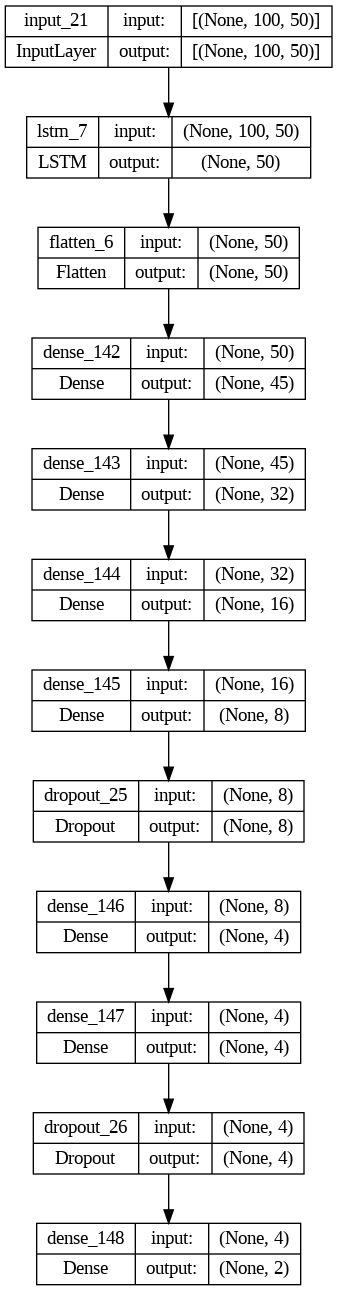

In [247]:
visible11 = Input(shape=(100,50))
hidden11 = LSTM(50, activation='relu', dropout=.5, recurrent_dropout=.2, return_sequences=False)(visible11)
hidden21 = Flatten()(hidden11)
hidden12 = Dense(45, activation='relu')(hidden21)
hidden13 = Dense(32, activation='relu')(hidden12)
hidden14 = Dense(16, activation='relu')(hidden13)
hidden15 = Dense(8, activation='relu')(hidden14)
drop11 = Dropout(.5)(hidden15)
hidden16 = Dense(4, activation='relu')(drop11) 


# interpretation model
hidden32 = Dense(4, activation='sigmoid')(hidden16)
drop31 = Dropout(.5)(hidden32)
output = Dense(2, activation='softmax')(drop31)


model = Model(inputs=visible11, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(X_test, y_test,
          validation_data=(X_test, y_test), 
          callbacks=[monitor],
          verbose=2, 
          epochs=100)  

m_pred = model.predict(X_test)
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

In [237]:
y_train.shape

(4677, 2, 1)

In [238]:
y_test.shape

(2005, 2, 1)

Epoch 1/50
147/147 - 2s - loss: 0.7088 - accuracy: 0.6000 - val_loss: 0.6503 - val_accuracy: 0.6065 - 2s/epoch - 13ms/step
Epoch 2/50
147/147 - 1s - loss: 0.6000 - accuracy: 0.6705 - val_loss: 0.7232 - val_accuracy: 0.6903 - 551ms/epoch - 4ms/step
Epoch 3/50
147/147 - 1s - loss: 0.5174 - accuracy: 0.7669 - val_loss: 0.5204 - val_accuracy: 0.7541 - 576ms/epoch - 4ms/step
Epoch 4/50
147/147 - 1s - loss: 0.4668 - accuracy: 0.7967 - val_loss: 0.7388 - val_accuracy: 0.5651 - 548ms/epoch - 4ms/step
Epoch 5/50
147/147 - 1s - loss: 0.4689 - accuracy: 0.7952 - val_loss: 0.5422 - val_accuracy: 0.7476 - 544ms/epoch - 4ms/step
Epoch 6/50
147/147 - 1s - loss: 0.4746 - accuracy: 0.7986 - val_loss: 0.7072 - val_accuracy: 0.7541 - 553ms/epoch - 4ms/step
Epoch 7/50
147/147 - 1s - loss: 0.3727 - accuracy: 0.8529 - val_loss: 0.6064 - val_accuracy: 0.7466 - 544ms/epoch - 4ms/step
Epoch 8/50
147/147 - 1s - loss: 0.3936 - accuracy: 0.8441 - val_loss: 0.5806 - val_accuracy: 0.6549 - 555ms/epoch - 4ms/step
Ep

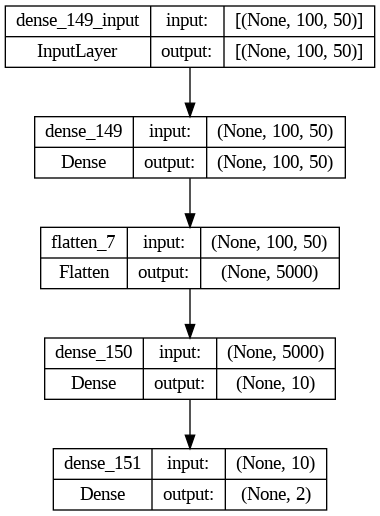

In [248]:
model = Sequential()
model.add(Dense(50, input_shape= (100,50), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(2))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True)

model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks = [monitor, checkpointer],verbose=2,epochs=50)

m_pred = model.predict(X_test)
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

In [249]:
layer = model.layers[0]
layer

In [250]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model,
                          layer=layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [252]:
x_test_sample = X_test[:nb_samples]
predictions = model(x_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions,
                         attribute_to_layer_inputs=False)

In [253]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 0},
 'version': '0.9.2'}

In [254]:
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [255]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


In [256]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


In [257]:
i = 1
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [258]:
print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

Predicted label =  1: Positive review


In [259]:
from IPython.display import HTML
def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"

In [260]:
def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    import matplotlib as mpl
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

In [ ]:
def decode_sentence(x, reverse_index):
    # the `-3` offset is due to the special tokens used by keras
    # see https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
    return " ".join([reverse_index.get(i - 3, 'UNK') for i in x])

In [282]:
words = []
for i in range(100):
  if(word2vec_model.wv.similar_by_vector(X[0][i], topn = 1)[0][1]!=0.0):
    words.append(word2vec_model.wv.similar_by_vector(X[3][i], topn = 1)[0][0])

print(words)

['this', 'game', 'with', 'its', 'cute', 'little', 'out', 'of', 'the', 'wall', 'pop', 'ups', 'that', 'scared', 'the', 'living', 'light', 'out', 'of', 'me', 'i', 'like', 'it', 'very', 'much', 'i', "haven't", 'played', 'it', 'lately', 'but', 'this', 'is', 'a', 'very', 'good', 'game', 'i', 'like', 'how', 'its', 'a', 'funny', 'jump', 'scare', 'game', 'and', 'it']


In [283]:
colors = colorize(attrs_i)

HTML("".join(list(map(hlstr, words, colors))))

<ipython-input-260-931a19a490c6>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


In [ ]:
"""
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
inputs = Input(shape=(100,50), dtype=tf.int32)
embedded_sequences = Embedding(max_features, embedding_dims)(inputs)

out = Conv1D(filters,
             kernel_size,
             padding='valid',
             activation='relu',
             strides=1)(embedded_sequences)
out = Dropout(0.4)(out)
out = GlobalMaxPooling1D()(out)
out = Dense(hidden_dims,
            activation='relu')(out)
out = Dropout(0.4)(out)

outputs = Dense(2, activation='softmax')(out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
"""

ValueError: ignored

In [ ]:
model.fit(X_train, y_train, batch_size = 256, epochs = 3, validation_data=(X_test, y_test))

Epoch 1/3


ValueError: ignored

In [ ]:
"""
vector_size = 200
window_size = 5
min_count = 5
epochs = 5

# Initialize the Word2Vec model
word2vec_model = Word2Vec( vector_size = vector_size, sg = 1, window = window_size, min_count = min_count, epochs = epochs )

# Build the vocabulary of the Word2Vec model
word2vec_model.build_vocab(all_vocab)

# Lock the vectors of the Word2Vec model
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))

# Load pre-trained vectors into the Word2Vec model (optional)
word2vec_model.wv.load_word2vec_format('drive/MyDrive/proj3/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

# Train the Word2Vec model on the vocabulary
word2vec_model.train(all_vocab, total_examples=len(all_vocab), epochs=5)

# Prepare the training and testing data
max_train_length = 150
max_test_length = 150
train_reviews_enum = np.zeros((len(X_train), max_train_length, vector_size), dtype=np.float32)
test_reviews_enum = np.zeros((len(X_test), max_test_length, vector_size), dtype=np.float32)

# Convert the training data into Word2Vec embeddings
for i, review in enumerate(X_train):
    for j, token in enumerate(review):
        if j >= max_train_length:
            break
        if token not in word2vec_model.wv:
            continue
        train_reviews_enum[i, j, :] = word2vec_model.wv[token]

# Convert the testing data into Word2Vec embeddings
for i, review in enumerate(X_test):
    for j, token in enumerate(review):
        if j >= max_test_length:
            break
        if token not in word2vec_model.wv:
            continue
        test_reviews_enum[i, j, :] = word2vec_model.wv[token]

"""

#Word Embeddings (Bert)
Context Sensitive embeddings

In [ ]:
sentences = df_train.user_review.values
labels = df_train.user_suggestion.values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.
Tokenized:  ['i', "'", 'm', 'scared', 'and', 'hearing', 'creepy', 'voices', '.', 'so', 'i', "'", 'll', 'pause', 'for', 'a', 'moment', 'and', 'write', 'a', 'review', 'while', 'i', 'wait', 'for', 'my', 'heart', 'beat', 'to', 'return', 'to', 'at', '##lea', '##st', 'somewhat', 'ca

In [ ]:
from transformers import TFBertModel

sentences = df_train.user_review.values
labels = df_train.user_suggestion.values

# Load the model and tokenizer
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 16
encoded_inputs = []
for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i:i+batch_size]
    encoded_input = tokenizer.batch_encode_plus(batch_sentences,max_length=32, padding=True, truncation=True, return_tensors='tf')
    encoded_inputs.append(encoded_input)

# Concatenate the batches
concatenated_input = {key: tf.concat([ei[key] for ei in encoded_inputs], axis=0) for key in encoded_inputs[0].keys()}

# Call the model with the concatenated input
hidden_states = model(concatenated_input['input_ids'], attention_mask=concatenated_input['attention_mask'], token_type_ids=concatenated_input['token_type_ids'], training=False).hidden_states
embeddings = hidden_states[-1]

# Print the embeddings
print(embeddings)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


tf.Tensor(
[[[-7.94039965e-01 -4.73578423e-01  6.75491989e-04 ... -4.55879748e-01
   -2.49066576e-01  2.75091290e-01]
  [-7.89083481e-01 -5.08083522e-01  1.07805705e+00 ... -6.01960719e-01
    2.29922682e-01 -3.89833003e-05]
  [-1.17574131e+00 -1.41494066e-01  1.27439022e-01 ... -2.96728730e-01
    4.13199663e-02  4.44689468e-02]
  ...
  [-1.12918317e+00  1.05955221e-01 -2.76450440e-02 ...  6.84670955e-02
    2.61279345e-01  8.15594271e-02]
  [-1.46215940e+00  1.06671348e-01  3.00930083e-01 ... -7.41673589e-01
   -3.36830139e-01  3.85465622e-01]
  [ 7.33468115e-01  4.81590489e-03 -3.15706968e-01 ...  9.06503275e-02
   -6.76844180e-01 -3.20170522e-01]]

 [[ 3.10125768e-01 -6.13615140e-02  4.49138820e-01 ... -1.67120188e-01
    2.56077051e-01  3.88249308e-01]
  [-1.07211553e-01 -2.75852412e-01  5.08719534e-02 ... -1.25511274e-01
    2.43903100e-01 -3.76950264e-01]
  [-7.24027976e-02 -1.21637762e-01  2.90740073e-01 ... -6.65840685e-01
   -1.47532113e-02 -7.49638021e-01]
  ...
  [ 4.516654

In [ ]:
encoded_input

{'input_ids': <tf.Tensor: shape=(14, 32), dtype=int32, numpy=
array([[  101,  2220,  3229,  3319, 15222,  2015,  2208,  6882, 16500,
        11721, 27821,  2078,  1998,  2707,  2043, 22752,  2059,  1012,
         1012,  1012,  2044,  2025,  2377,  2023,  2208,  2005,  1037,
         2733,  1010, 26828,  2006,   102],
       [  101,  2220,  3229,  3319,  1855,   100,   100,   100,  1746,
         1861,  2057,  2342,  2822,  1746,  1799,  1950,  1672,   100,
          100,  2053,  2271, 16131,  2015,  2022,  6499,  2378,  2139,
         5413, 10054,  9148,  2099,   102],
       [  101,  2220,  3229,  3319, 10841, 17417,  2638, 24483,  7545,
         1037, 29257,  1998, 20368, 13288,  9792,  2000,  1996,  2208,
         1997,  2645, 24483,  1012, 28699,  2015,  1024, 17368,  1024,
         1045,  2581, 25535,  2692,   102],
       [  101,  2220,  3229,  3319, 10994,  2015,  1997,  4569,   999,
          999,   999,  2145,  2220,  2007,  2023,  2208,  2021,  2043,
         3929,  2764,  10

In [ ]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 32
nb_samples = 16
ig  = IntegratedGradients(model,
                          layer=embeddings,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

TypeError: ignored

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

#Format the sentence into a way that Bert requires.
#Add the SEP and CLS markers for each sentence.
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                        # Sentence to encode.
                        add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
                        max_length = 150,            # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   #Set where to add the zeros for padding
                        return_tensors = 'pt',       # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # Add the indexes where padding should be done.
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

#('Attention Masks:', attention_masks[0])
#print('labels:', labels[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.
Token IDs: tensor([  101,  1045,  1005,  1049,  6015,  1998,  4994, 17109,  5755,  1012,
         2061,  1045,  1005,  2222,  8724,  2005,  1037,  2617,  1998,  4339,
         1037,  3319,  2096,  1045,  3524,  2005,  2026,  2540,  3786,  2000,
         2709,  2000,  2012, 1973

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

#Create a 90/10 split for training and validation. NOT THE TEST SET.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,760 training samples
  640 validation samples


In [ ]:
batch_size = 32

#Dataloader for training set.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

#Dataloader for validation set.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
#Load BertForSequenceClassification, the pretrained BERT model 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)
#Run the model on GPU
model.cuda()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
#Set the optimizer for the model.
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 4

#Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).to_tuple()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).to_tuple()
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:08.
  Batch    80  of    180.    Elapsed: 0:00:16.
  Batch   120  of    180.    Elapsed: 0:00:24.
  Batch   160  of    180.    Elapsed: 0:00:32.

  Average training loss: 0.37
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.26
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:08.
  Batch    80  of    180.    Elapsed: 0:00:16.
  Batch   120  of    180.    Elapsed: 0:00:24.
  Batch   160  of    180.    Elapsed: 0:00:32.

  Average training loss: 0.18
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.31
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:08.
  Batch    80  of    180.    Elapsed: 0:00:16.
  Batch   120  of    180.    Elapsed: 0:00:24.
  Batch   160  of    180.    Elapsed: 0:00:32.



In [ ]:
emb = model

AttributeError: ignored

In [ ]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.364846,0.246700,0.903125,0:00:36,0:00:01
2,0.186654,0.272632,0.896875,0:00:36,0:00:01
3,0.106037,0.317656,0.898438,0:00:36,0:00:01
4,0.063662,0.356045,0.900000,0:00:36,0:00:01


In [ ]:
#For the Test dataset
# Create sentence and label lists
sentences = df_test.user_review.values
labels = df_test.user_suggestion.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,600 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.user_suggestion.sum(), len(df_test.user_suggestion), (df_test.user_suggestion.sum() / len(df_test.user_suggestion) * 100.0)))

Positive samples: 964 of 1600 (60.25%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-143-e401f6011a3f>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


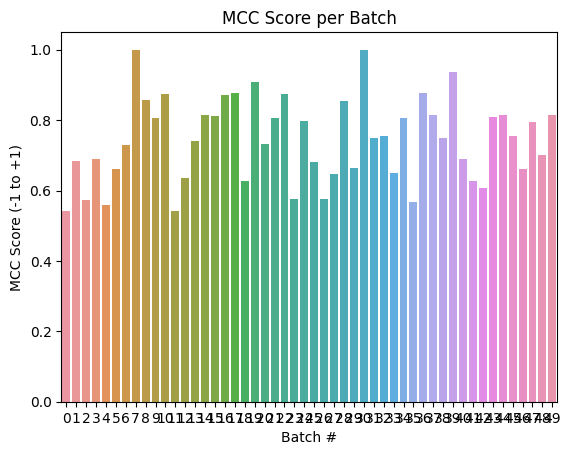

In [ ]:
import seaborn as sns
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.748
